# The Magic of SHD
> A simple yet fast and powerful forecasting algorithm

- toc: true 
- badges: true
- comments: true
- categories: [pandas, numpy, data-cleaning]
- hide: false

## What's SHD?


SHD stands for (S)ingle Exponential Smoothing, (H)olt's, (D)amped forecasting algorithm. It's not often that you can describe the entire algorithm in one single sentence but I just did that. And this simple algorithm often outperforms some of the most complex forecasting algorithms including DNNs and FB Prophet on univariate low frequency time series. I have used it on many projects successfully with great results. I am sharing it because the great [Spyros Makridakis](https://www.insead.edu/faculty-research/faculty/spyros-makridakis) reminded on twitter that SHD was found superior in all M (M5 would be an exception) competitions.      

>twitter: https://twitter.com/spyrosmakrid/status/1368972398498824193?s=20

Not many know about this gem so I thought I would share my code. It's a reminder that you don't always need complex algorithms to create forecast predictions. Use what's simple and parsimonious.  

**How does it work?**

Just take arithmatic mean of forecast from SES, Holt's and Damped

![shd](https://raw.githubusercontent.com/pawarbi/blog/master/images/shd.JPG)

**How does it stack against other algorithms?**

[Read it yourself](https://flora.insead.edu/fichiersti_wp/inseadwp1999/99-70.pdf). It worked as good and even better than most other algorithms in the M3 competition. It works particularly well with low frequency time series (Yearly, monthly). It works well because we are ensembling three different algorithms. It's been shown that forecast combinations often outperform single best models.   

I will demonstrate it using an example below. This is the same dataset I used in my two previous [blogs](https://pawarbi.github.io/blog/forecasting/r/python/rpy2/altair/fbprophet/ensemble_forecast/uncertainty/simulation/2020/04/21/timeseries-part2.html).



In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing

import scipy
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from statsmodels.tools.eval_measures import rmse

In [23]:
print('Pandas:', pd.__version__)
print('Statsmodels:', sm.__version__)
print('Scipy:', scipy.__version__)
print('Numpy:', np.__version__)

Pandas: 1.1.5
Statsmodels: 0.12.2
Scipy: 1.5.2
Numpy: 1.19.1


### SHD

In [24]:
def combshd(train,horizon,seasonality, init):

#     Author: Sandeep Pawar
#     Date: 8/30/2020
#     version: 1.1

    '''
    params
    ----------
        :train numpy array or Pandas series with univariate data
        
        :horizon forecast horizon (int)
        
        :seasonality For monthly 12, yearly 1, quarerly 4 (int)
        
        :init initialization ('heuristic','concentrated')
    
    output
    ------------
    numpy array if length equal to specified horizon
    
    '''
    
    train_x,lam = boxcox (train)
    ses=(sm.tsa.statespace.ExponentialSmoothing(train_x,
                                           trend=True, 
                                           seasonal=None,
                                           initialization_method= init, 
                                           damped_trend=False).fit())
    
    fc1 = inv_boxcox(ses.forecast(horizon),lam)
    
    holt=(sm.tsa.statespace.ExponentialSmoothing(train_x,
                                           trend=True, 
                                           seasonal=seasonality,
                                           initialization_method= init, 
                                           damped_trend=False).fit())
    
    fc2 = inv_boxcox(holt.forecast(horizon),lam)
    
    damp=(sm.tsa.statespace.ExponentialSmoothing(train_x,
                                           trend=True, 
                                           seasonal=seasonality,
                                           initialization_method= init, 
                                           damped_trend=True).fit())
    
    fc3 = inv_boxcox(damp.forecast(horizon),lam)
    
    fc = (fc1+fc2+fc3)/3
    
    return fc


In [25]:
data = pd.read_csv("https://raw.githubusercontent.com/pawarbi/datasets/master/timeseries/ts_frenchretail.csv")

data['Date']= pd.to_datetime(data['Date'])
data.set_index('Date', inplace= True)


train = data.iloc[:-4]
test = data.iloc[-4:]

data.head()

,Sales
Date,
2012-03-31,362000
2012-06-30,385000
2012-09-30,432000
2012-12-31,341000
2013-03-31,382000


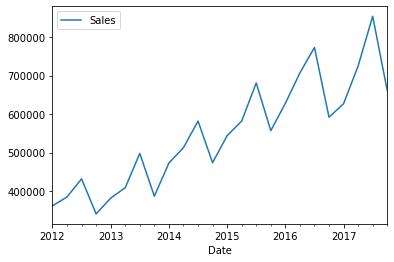

In [26]:
data.plot();

In [27]:

print("Train legth:", len(train), "\nTest legth:",len(test))

assert len(data)==len(train) + len(test)

Train legth: 20 
Test legth: 4


#### Create forecast

In [28]:
shd_pred = combshd(train = train['Sales'].values,horizon=len(test),seasonality = 4, init = 'heuristic')

In [29]:
rmse(test['Sales'].values,shd_pred ).round(0)

63734.0

RMSE using SHD is 63734. For comparison, [FB Prophet](https://pawarbi.github.io/blog/forecasting/r/python/rpy2/altair/fbprophet/ensemble_forecast/uncertainty/simulation/2020/04/21/timeseries-part2.html#Facebook-Prophet) gave ~66,000 and [SARIMA](https://pawarbi.github.io/blog/forecasting/r/python/rpy2/altair/fbprophet/ensemble_forecast/uncertainty/simulation/2020/04/21/timeseries-part2.html#SARIMA2---(Using-Logged-value)) was ~82,000. I was able to further improve this by ensembling many algorithms but still it's impressive that with just lines of code you can create a sophisticated algorithm ! 

So a reminder, **always start with baseline simple algorithms**. In practice, [fast and frugal](https://arxiv.org/abs/2102.13209) wins the long race.